In [1]:
import json
import os
import re
import nltk
import time
import pickle
from nltk import pos_tag
from six import string_types

from nltk.tokenize import TweetTokenizer

from nltk.corpus.reader.util import StreamBackedCorpusView, concat, ZipFilePathPointer
from nltk.corpus.reader.api import CorpusReader

DOC_PATTERN = r'.*\.json' 
# PKL_PATTERN = r'.*\.pickle'

##########################################################################
## Tweets Corpus Reader
##########################################################################

class TweetsCorpusReader(CorpusReader):

    """
    Reader for corpora that consist of Tweets represented as a list of line-delimited JSON.
    Individual Tweets can be tokenized using the default tokenizer, or by a
    custom tokenizer specified as a parameter to the constructor.
    Construct a new Tweet corpus reader for a set of documents
    located at the given root directory.
    If you want to work directly with the raw Tweets, the `json` library can
    be used::
       import json
       for tweet in reader.docs():
           print(json.dumps(tweet, indent=1, sort_keys=True))
    """

    CorpusView = StreamBackedCorpusView  # The corpus view class used by this reader.

    def __init__(self, root, fileids=None, word_tokenizer=TweetTokenizer(), encoding='utf-8-sig', bullying_trace='bullying_trace'):

        CorpusReader.__init__(self, root, fileids, encoding, bullying_trace)

        for path in self.abspaths(self._fileids):
            if isinstance(path, ZipFilePathPointer):
                pass
            elif os.path.getsize(path) == 0:
                raise ValueError("File {} is empty".format(path))
        """Check that all user-created corpus files are non-empty."""

        self._word_tokenizer = word_tokenizer
        self._bullying_trace = bullying_trace
    
    def _read_tweets(self, stream):
        """
        Assumes that each line in ``stream`` is a JSON-serialised object.
        """
        tweets = []
        for i in range(10):
            line = stream.readline()
            if not line:
                return tweets
            tweet = json.loads(line)
            tweets.append(tweet)
        return tweets

    def docs(self, fileids=None, bullying_trace=None):
        """
        Returns the full Tweet objects, 
        :return: the given file(s) as a list of dictionaries deserialised from JSON.
        :rtype: list(dict)
        """
        tweets = concat(
            [
                self.CorpusView(path, self._read_tweets, encoding=enc)
                for (path, enc, fileid) in self.abspaths(fileids, True, True)
            ])
        
        tweets = [tweet for tweet in tweets]

        if self._bullying_trace=='bullying_trace':
            remove = ['nan','remove']
            tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) not in remove]
        if self._bullying_trace=='bullying_role':
            tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']
        elif self._bullying_trace=='form_of_bullying':
            tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']
        elif self._bullying_trace=='bullying_post_type':
            tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']           
        else:
            tweets

        return tweets 
        
    # def docs(self, fileids=None, bullying_trace=None):
    #     """
    #     Returns the full Tweet objects, 
    #     :return: the given file(s) as a list of dictionaries deserialised from JSON.
    #     :rtype: list(dict)
    #     """
    #     tweets = concat(
    #         [
    #             self.CorpusView(path, self._read_tweets, encoding=enc)
    #             for (path, enc, fileid) in self.abspaths(fileids, True, True)
    #         ])
        
    #     # if self._bullying_trace=='bullying_trace':
    #     #     new_tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) =='yes']
    #     if self._bullying_trace=='bullying_role':
    #         new_tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']
    #     elif self._bullying_trace=='form_of_bullying':
    #         new_tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']
    #     elif self._bullying_trace=='bullying_post_type':
    #         new_tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) !='nan']           
        
    #     else:
    #         remove = ['nan','remove']
    #         new_tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) not in remove]

    #     return new_tweets
    #     # return tweets 
           
    def sizes(self, fileids=None):
        """
        Returns a list of tuples, the fileid and size on disk of the file.
        This function is used to detect oddly large files in the corpus.
        """
        # Create a generator, getting every path and computing filesize
        for path in self.abspaths(fileids):
            yield os.path.getsize(path)

    def fields(self, fields, fileids=None):
        """
        extract particular fields from the json doc. Can be string or an 
        iterable of fields. If just one fields in passed in, then the values 
        are returned, otherwise dictionaries of the requested fields returned
        """
        if isinstance(fields, string_types):
            fields = [fields,]

        if len(fields) == 1:
            for doc in self.docs(fileids):
                if fields[0] in doc:
                    yield doc[fields[0]]

        else:
            for doc in self.docs(fileids):
                yield {
                    key : doc.get(key, None)
                    for key in fields
                }
    
    def strings(self, fileids=None):
        """
        Returns only the text content of Tweets in the file(s)
        :return: the given file(s) as a list of Tweets.
        :rtype: list(str)
        """
        fulltweets = self.docs(fileids)
        tweets = []
        for jsono in fulltweets:
            try:
                text = jsono['full_tweet']
                if isinstance(text, bytes):
                    text = text.encode('latin-1').decode('utf-8') #.decode(self.encoding) #
                tweets.append(text)
            except KeyError:
                pass
        return tweets

    def tokenized(self, fileids=None):
        """
        :return: the given file(s) as a list of the text content of Tweets as
        as a list of words, screenanames, hashtags, URLs and punctuation symbols.
        :rtype: list(list(str))
        """
        tweets = self.strings(fileids)
        tokenizer = self._word_tokenizer
        tokenized = [tokenizer.tokenize(t) for t in tweets]
        return [ pos_tag(token) for token in tokenized ]
    
    def process_tweet(self, fileids=None):

		# emoji_pattern = re.compile("["
        # u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        # u"\U0001F680-\U0001F6FF"  # transport & map symbols
        # u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"
        # "]+", flags=re.UNICODE)
        tagged_tweets = self.tokenized(fileids)
        mod_tweets = []
        for tweet in tagged_tweets:
            mod_tweet=[]
            for (token, tag) in tweet:    
                if '@' in token:
                    token = '@user'
                elif '#' in token:
                    token = token[1:]
                elif ('http' or 'https') in token:
                    token = 'UR'
                elif token == 'luv':
                    token = 'love'
                else:
                    pass
                mod_tweet.append((token,tag))
            mod_tweets.append(mod_tweet)
        return mod_tweets

    def raw(self, fileids=None):
        """
        Return the corpora in their raw form.
        """
        if fileids is None:
            fileids = self._fileids
        elif isinstance(fileids, string_types):
            fileids = [fileids]
        return concat([self.open(f).read() for f in fileids])

    def describe(self, fileids=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()
        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Compute the number of files and categories in the corpus
        n_fileids = len(self.fileids())

        # Perform single pass over paragraphs, tokenize and count
        for tweet in self.tokenized(fileids):
            counts['tweets'] += 1

            for word in tweet:
                counts['words'] += 1
                tokens[word] += 1
            # print(counts, tokens)

        # Return data structure with information
        return {
            'files':  n_fileids,
            'tweets':  counts['tweets'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': float(counts['words']) / float(len(tokens)),
            'twdoc':  float(counts['tweets']) / float(n_fileids),
            'mins':   (time.time() - started)/60,
        }
    
    def describes(self, fileids=None, categories=None):
        """
        Returns a string representation of the describe command.
        """
        return (
            "This twitter corpus contains {files} files.\n"
            "Structured as:\n"
            "    {tweets} tweets ({twdoc:0.3f} mean tweets per file)\n"
            "    Word count of {words} with a vocabulary of {vocab}\n"
            "    ({lexdiv:0.3f} lexical diversity).\n"
            "Corpus scan took {mins:0.3f} minutes."
        ).format(**self.describe(fileids))

In [2]:
from pathlib import Path
import pandas as pd
import os


# ROOT = Path('C:\\Users\\niti.mishra\\Documents\\Personal\\cyberbullying\\') # windows
ROOT = Path('/Users/peaceforlives/Documents/Projects/cyberbullying/')         # mac
CORPUS = Path.joinpath(ROOT, 'data', 'labelled_tweets', 'ab')
DOC_PATTERN = r'.*\.json' 
target = 'bullying_trace'

corpus = TweetsCorpusReader(CORPUS.__str__(), DOC_PATTERN, bullying_trace=target)        
X = pd.DataFrame(corpus.strings())
X['y'] = list(corpus.fields(target))
pd.options.display.max_colwidth = 5000
X.head()

,0,y
0,"@heyyyitsbieha bullying and helping is two different things,i didn’t force him,im not using the rock’s voice or the big show’s slam,i’m just asking him if he’s free and would like to help,but i’m agreeing with you that bullying is a trash behavior!✌🏻",yes
1,@umineko_lover @mienumirai i mean it has some really graphic depictions of bullying and is pretty depressing at times but the ending (of the first game at least) is good and has that message.,no
2,my take on social issues like this is that everything sucks because everything sucks.\n\nvictim was probably bullied into submission directly and indirectly. perpetrator did it because he wanted to be grown up so fast because his family situation sucked which-,yes
3,"i want to watch a group of characters ranging in the spectrum of kind-hearted to decent enough to tolerate be goofy, funnily stupid or god for once witty. not a bunch of bitches bully each other with a laugh track in the background.",no
4,i’d never let a fucking fetus on twitter bully me into deactivating got me fucked up. bitch i’ll literally shove u back into ur mother’s womb,no


In [3]:
X.shape

(7868, 2)

In [4]:
import glob 
from pathlib import Path
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
PATH = r'/Users/peaceforlives/Documents/Projects/cyberbullying/final_classification/results/'
data = pd.read_pickle(PATH+'data_docs.pkl')
data_docs = pd.read_pickle(PATH+'full_data.pkl')

In [8]:
cols = ['bullying_trace', 'bullying_role', 'form_of_bullying', 'bullying_post_type']
df = pd.concat([data_docs, data[cols]], axis=1)
df.loc[df['bullying_trace']=='no', 'bullying_trace'] = 'NA'
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = [i.date() for i in df['created_at']]
df.head()

,created_at,id,source,geo,coordinates,place,lang,full_tweet,timezone,localtime,state,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,date,datestr
0,2019-08-07 14:13:45+00:00,1159105350747901953,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",None,None,None,en,"i mean most @ my school are fine, but the kpop dance club being koreaboos when they see any asian (and especially me being korean-american) are the ones that are rightfully bullied",None,None,None,yes,reporter,general,self-disclosure,2019-08-07,2019-08-07
1,2019-08-07 14:14:36+00:00,1159105565794217984,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",None,None,None,en,"@dhb_dian @msnbc @joenbc you are showing your low intelligence. it was done by castro as a bullying tactic, and as a mccarthyite-tactic threat to anyone considering donating in the future, to shut them down! castro is endangering their lives and he knows it. but media won't hold him accountable!",None,None,None,NA,NA,NA,NA,2019-08-07,2019-08-07
2,2019-08-07 14:14:40+00:00,1159105583246655496,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,"@binkybooboos @cricri51391727 @renemyriam1 @nancynofriends @rocking_with_u @lazycat48576974 @max_one_77 @mycatinblack @pbillink @valhall32843068 @lisarroberts @rhubarb_rules @jubisay6 @amara__df @hollyglly @betsywrene @asynja_gem @robintetley @poetcalloway @chrissybug5000 @ncanarchist @faux_dan_ @eddie_drood @envypost @danreed100 @amospictures1 @nessie43 @candypinnow @oppermanreport @didimond @jaimied12 @nina82997364 @dash4442 @jnon_fan @ameetatweet @sweetgeekling @betrayed_bitch @tcu_gofrogs @sos12017 @ddssy @elguapobandz @exposingjacko @evelyne1370 @jacarpb @0pinion8d @pookysoupy @glowtree3 @hssfanme @hellshousewife @mjisguilty i agree - it is a sickness, but being respectful to them and explaining things to them back in march got my account ransacked, my name, my face, my tweets and ss of my youtube account were spread around twitter for other fans to abuse, bully and stalk me so idgaf about them now.",None,None,None,NA,NA,NA,NA,2019-08-07,2019-08-07
3,2019-08-07 14:14:47+00:00,1159105611684089856,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,"@jayb_1411 that’s why i hate that people now consider that bullying, that made me who i am i use to get scored on all the time when i had braces you gotta be able to laugh at urself",None,None,None,yes,victim,general,self-disclosure,2019-08-07,2019-08-07
4,2019-08-07 14:15:07+00:00,1159105696325152768,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",None,None,None,en,@kate_mma online bullying from kate..sad to see,None,None,None,NA,NA,NA,NA,2019-08-07,2019-08-07


In [10]:
# df['datestr'] = [i.date().strftime('%Y-%m-%d') for i in df['created_at']]
df['wkday'] = [i.weekday() for i in df['created_at']]
df = df[df.datestr != '2020-04-01']

In [202]:
# df.set_index('created_at', inplace=True)
pd.options.display.max_colwidth = 5000
df['20191015':'20191015']

,id,source,geo,coordinates,place,lang,full_tweet,timezone,localtime,state,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,date
created_at,,,,,,,,,,,,,,,
2019-10-15 00:00:02+00:00,1183895267495546881,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,@link_dennis7467 @montanadan30 she made a kpop idol ( i really don’t wanna day her name but it happened today) suicide due to bullying and constant harassment about her instead of just giving her condolences and moving forward,None,None,None,yes,reporter,general,report,2019-10-15
2019-10-15 00:00:08+00:00,1183895292845940738,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,it’s unseemly to watch a senior bbc journalist using his fame to bully an airline for a delay. we all get delayed sometimes. it happens. no need to make it an online drama.,None,None,None,NA,NA,NA,NA,2019-10-15
2019-10-15 00:00:12+00:00,1183895311447556097,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,"{'id': '4b25aded08900fd8', 'url': 'https://api.twitter.com/1.1/geo/id/4b25aded08900fd8.json', 'place_type': 'city', 'name': 'Reno', 'full_name': 'Reno, NV', 'country_code': 'US', 'country': 'United States', 'bounding_box': {'type': 'Polygon', 'coordinates': [[[-119.953849, 39.350749], [-119.953849, 39.674123], [-119.700515, 39.674123], [-119.700515, 39.350749]]]}, 'attributes': {}}",en,"@kitzemcc @hippy_patriot_ @gwyn88904784 agreed, experts say the best way to deal with a narcissistic psychotic bully is first ignore, suck the oxygen from his 🔥, then ridicule.",None,None,None,NA,NA,NA,NA,2019-10-15
2019-10-15 00:00:43+00:00,1183895442909810688,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,let’s not make sulli’s death about her breasts. it’s about the endless torment she had to endure. she is not a bad person. online bullying is wrong,None,None,None,NA,NA,NA,NA,2019-10-15
2019-10-15 00:00:51+00:00,1183895472991342592,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",None,None,None,en,@saltyyugi @moxymayham @oliviamaefgc ignore him he is a bully lol,None,None,None,NA,NA,NA,NA,2019-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15 23:57:26+00:00,1184257001469157377,"<a href=""http://www.socialflow.com"" rel=""nofollow"">SocialFlow</a>",None,None,None,en,bullying suspected in 10-year-old girl's suicide https://t.co/7p5jtpj9lv,None,None,None,NA,NA,NA,NA,2019-10-15
2019-10-15 23:58:59+00:00,1184257392491532288,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,@eyesonq big guy ought to be ripping them masks off like we about to find out who mr wrestling #2 is! how do you handle a bully? hit them square in that trap!,None,None,None,NA,NA,NA,NA,2019-10-15
2019-10-15 23:59:02+00:00,1184257405317566464,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",None,None,None,en,@noahfinnadams lel just because people used the word to bully you doesnt mean you get to shit on a whole ass identity. lel theres no excuse for the shit you said. what was said was disgusting and youve proven that its impossible to find trustable icons who respect lesbians.,None,None,None,yes,defender,general,report,2019-10-15


In [7]:
n_tweets = df['date'].groupby(df['date']).count()
n = 20
n_max = n_tweets.nlargest(n).sort_index()
x = n_max.index
y = n_max.values
idx = n_tweets.argsort()[-n:][::-1]
n_max
# ['national bullying prevention month']

date
2019-10-01     4572
2019-10-14     7555
2019-10-15     4845
2019-11-15     4743
2019-12-12     4549
2020-02-15     7477
2020-02-16     6955
2020-02-17     4631
2020-02-18     5628
2020-02-19     4650
2020-02-20     8103
2020-02-21    18575
2020-02-22     8731
2020-02-23     5302
2020-02-24     4782
2020-02-25     4841
2020-03-03     4545
2020-03-04     5098
2020-03-05     4563
2020-03-06     4908
Name: date, dtype: int64

IndexError: index 5 is out of bounds for axis 0 with size 5

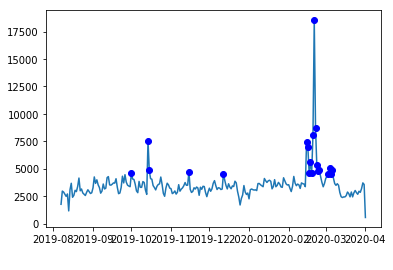

In [13]:
plt.plot(n_tweets)
plt.plot(n_max, 'ro', c='b')   
for i, txt in enumerate(x):
    ax.annotate(txt, (idx[i], y[i]))
plt.xlabel("date")
plt.ylabel("no. of tweets")
plt.title("No of tweets by date")

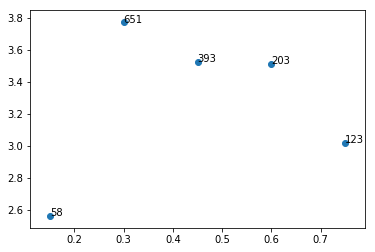

In [12]:
y = np.array([2.56422, 3.77284, 3.52623, 3.51468, 3.02199])
z = np.array([0.15, 0.3, 0.45, 0.6, 0.75])
n = np.array([58, 651, 393, 203, 123])

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [66]:

# years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%b-%d')

plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)  

plt.plot(n_tweets)
plt.plot(x_max, y_max, 'ro', c='b')#, label='Anti-Bullying Day')
plt.xlabel("date")
plt.ylabel("no. of tweets")
plt.title("No of tweets by date")
# plt.xticks(rotation=45)

# ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(days)
plt.legend(loc='upper left', frameon=False)
# plt.savefig('date.pdf', bbox_inches='tight')
# ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))   #to get a tick every 15 minutes
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 

ValueError: view limit minimum -36804.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36804.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x360 with 1 Axes>

In [17]:
df['bullying_trace'].value_counts()

no     599662
yes    240018
Name: bullying_trace, dtype: int64

In [7]:
# cols = ['full_tweet', 'bullying_trace', 'bullying_role', 'form_of_bullying', 'bullying_post_type']
# df = data[cols]
# df = df.sample(frac=1)
# pd.options.display.max_colwidth = 5000
# df.head(50)

In [8]:
b_trace = data[data['bullying_trace']=='yes']
b_trace.shape

(287080, 14)

In [9]:
b_trace.head()

,created_at,id,geo,coordinates,place,lang,full_tweet,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,timezone,localtime,state
0,2019-08-07 14:13:45+00:00,1159105350747901953,None,None,None,en,"i mean most @ my school are fine, but the kpop...",yes,victim,general,self-disclosure,None,None,None
3,2019-08-07 14:14:47+00:00,1159105611684089856,None,None,None,en,@jayb_1411 that’s why i hate that people now c...,yes,victim,general,self-disclosure,None,None,None
9,2019-08-07 14:18:23+00:00,1159106516844044291,None,None,None,en,@namaslays apparently claims of bullying a cre...,yes,reporter,cyber,report,None,None,None
12,2019-08-07 14:30:40+00:00,1159109609241665536,None,None,None,en,@yslattess i am being falsely targeted and acc...,yes,victim,general,self-disclosure,None,None,None
13,2019-08-07 14:30:50+00:00,1159109651113414657,None,None,None,en,okay that fuck # mjfam bullshit is q fucking b...,yes,defender,cyber,report,None,None,None


In [63]:
for column in b_trace.iloc[:,8:11]:
    print(b_trace[column].value_counts())

victim      113486
reporter     91116
defender     62654
accuser      16197
bully         3171
other          456
Name: bullying_role, dtype: int64
general     195379
cyber        90958
physical       657
verbal          86
Name: form_of_bullying, dtype: int64
report             117739
self-disclosure    102315
accusation          67025
denial                  1
Name: bullying_post_type, dtype: int64


In [72]:
pd.options.display.max_colwidth = 50
test = b_trace[b_trace['bullying_role']=='bully']
# test = b_trace[~b_trace['full_tweet'].str.match('love')]
# test.iloc[:,6]
test.shape

(3171, 14)

In [85]:
geo_data = data[data['timezone'].notnull()]
geo_data.shape

(268, 14)

In [88]:
pd.options.display.max_colwidth = 1000
geo_data.drop(['geo','coordinates','place','lang'], axis=1, inplace=True)
geo_data

//anaconda3/envs/twitter_cyberbullying/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,created_at,id,full_tweet,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,timezone,localtime,state
438,2019-08-07 16:41:16+00:00,1159142476520673281,"devote your energy to something greater than yourself. you’ll undoubtedly be hated for it. you’ll be bullied, intimidated, called every name in the book and maybe even killed. but truth lasts and illusions fade. do… https://t.co/httiqpeimd",no,reporter,general,report,America/Los_Angeles,2019-08-07 09:41:16 PDT-0700,Oregon
1400,2019-08-07 21:54:53+00:00,1159221398172102656,https://t.co/dcgfsfxogy operation #dropoutjeep \nthey can control/intercept/reroute apple products communication like iphones and easily destroy lives with their #cyberbullying… https://t.co/hequxeqxus,no,accuser,cyber,report,America/Detroit,2019-08-07 17:54:53 EDT-0400,Michigan
1702,2019-08-07 23:38:51+00:00,1159247564081979392,performing live at @biglumusic \notg_fashawn bout to have the ground shaking! hit him up for tickets. all age event 🎯🔥🔥🔥\notg🖤\n3632 nw 25th st 33142\n(club bully) 10pm - 3am\nladies in free all night 💰\n•\n•\n@biglumusic… https://t.co/iylncn2lgm,no,reporter,general,report,America/New_York,2019-08-07 19:38:51 EDT-0400,Florida
3099,2019-08-08 12:02:41+00:00,1159434756318269441,"✔🆓️ parent workshop sat 8/10 - learn about online privacy, prevent cyberbullying and more... register: https://t.co/2a5yalypsn \ngetting ready for #backtoschool 🏫 ? @cityofdoral comcast are sponsoring… https://t.co/gqdbusbozf",no,reporter,cyber,report,America/New_York,2019-08-08 08:02:41 EDT-0400,Florida
4071,2019-08-08 20:05:03+00:00,1159556148153864192,#repost @mjcsolutions\n• • • • •\nthis offer is exclusive for you! \nonly $9.99 link in bio\n\n✔are you dealing with a toxic boss?\n✔is your boss a bully? \n✔are you the bully? \n\nenroll in this quick 28 minutes online… https://t.co/mjy3evjczd,no,defender,cyber,accusation,America/Los_Angeles,2019-08-08 13:05:03 PDT-0700,California
...,...,...,...,...,...,...,...,...,...,...
795255,2020-03-16 20:34:28+00:00,1239651266348843008,"don’t stand for republican bullying!!!! they still haven’t forced companies to stop making us come in for work, then they can’t force us not to get out and vote!!!! this is a republican ploy to stop us from kicking… https://t.co/w37vdbxifo",no,defender,general,report,America/New_York,2020-03-16 16:34:28 EDT-0400,Ohio
800017,2020-03-18 16:39:22+00:00,1240316877705891841,"it is with great sorrow that we announce we will temporary close until the current situation has receded.\n\nwe have tried to remain open in a safe manner however have had several people bully us online and in person,… https://t.co/wjq7y60m98",no,defender,cyber,report,America/Los_Angeles,2020-03-18 09:39:22 PDT-0700,California
824303,2020-03-27 14:13:56+00:00,1243541770924892162,https://t.co/5fjvchuuok has links to every movie i'm in that's available to watch online. this pic is from bully! just released this year! will you watch it pls? tell me what you think? it's available on basically every… https://t.co/jabj375neg,yes,victim,cyber,report,America/New_York,2020-03-27 10:13:56 EDT-0400,New Jersey
834979,2020-03-30 21:00:15+00:00,1244731185164480512,this is what my day has been. \nwho in the actual heck gave this girl the right to &amp; bully me through private messages on instagram &amp; facebook? i've been bullied my whole entire life &amp; words can hurt &amp; no one will… https://t.co/4vxxrc9cpy,yes,victim,general,self-disclosure,America/Chicago,2020-03-30 16:00:15 CDT-0500,Florida


In [106]:
geo_data['state'].value_counts().to_clipboard()

In [109]:
geo_data.groupby('state')['bullying_trace'].count()

state
Alabama              5
Alaska               1
Alberta              3
Arizona              4
British Columbia     2
California          44
Colorado             4
Connecticut          6
Delaware             2
Florida             19
Georgia              6
Illinois             4
Kansas               1
Kentucky             1
Louisiana            6
Manitoba             2
Maryland             5
Massachusetts        2
Michigan            11
Minnesota            1
Missouri             3
Montana              1
Nebraska             1
Nevada               4
New Jersey           3
New York            12
North Carolina       4
North Dakota         2
Nova Scotia          2
Ohio                 4
Ontario             22
Oregon               4
Pennsylvania        12
Québec              19
Saskatchewan         1
South Carolina       1
Tennessee            7
Texas               21
Utah                 2
Virginia             5
Washington           4
West Virginia        3
Wisconsin            2
Name:

In [118]:
geo_bully = geo_data[geo_data['bullying_trace']=='yes']
geo_bully.shape

(60, 10)

In [119]:
time = geo_bully.copy()
time = time[['bullying_trace','bullying_role','form_of_bullying','bullying_post_type','timezone','localtime']]
time.head()

,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,timezone,localtime
16546,yes,victim,cyber,self-disclosure,America/Toronto,2019-08-13 06:29:41 EDT-0400
39524,yes,reporter,general,report,America/New_York,2019-08-21 09:56:26 EDT-0400
48072,yes,victim,general,self-disclosure,America/Los_Angeles,2019-08-23 18:12:49 PDT-0700
80390,yes,victim,general,self-disclosure,America/Los_Angeles,2019-09-03 10:48:19 PDT-0700
107754,yes,reporter,general,report,America/New_York,2019-09-11 18:19:16 EDT-0400


In [124]:
time['time'] = pd.to_datetime(time['localtime']) #, format='%d%b%Y:%H:%M:%S.%f')
time.head()

,bullying_trace,bullying_role,form_of_bullying,bullying_post_type,timezone,localtime,time
16546,yes,victim,cyber,self-disclosure,America/Toronto,2019-08-13 06:29:41 EDT-0400,2019-08-13 06:29:41-04:00
39524,yes,reporter,general,report,America/New_York,2019-08-21 09:56:26 EDT-0400,2019-08-21 09:56:26-04:00
48072,yes,victim,general,self-disclosure,America/Los_Angeles,2019-08-23 18:12:49 PDT-0700,2019-08-23 18:12:49+07:00
80390,yes,victim,general,self-disclosure,America/Los_Angeles,2019-09-03 10:48:19 PDT-0700,2019-09-03 10:48:19+07:00
107754,yes,reporter,general,report,America/New_York,2019-09-11 18:19:16 EDT-0400,2019-09-11 18:19:16-04:00


In [139]:
time['time'].value_counts().sort_index()